In [1]:
import chardet
import numpy as np
import pandas as pd
import datetime
import codecs

import os
import glob

import progressbar
from time import sleep

import matplotlib.pyplot as plt
import seaborn as sns

## Load and Format the Data
---

In [58]:
# specify filename to load for processing and aggregation
filename = './data/Raw-Data/reservations2016.csv'

In [59]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [60]:
# attempt to load the data using various codecs
types_of_encoding = ["utf8", "cp1252"]
for encoding_type in types_of_encoding:
    with codecs.open(filename, encoding = encoding_type, errors ='replace') as csvfile:
        rez = pd.read_csv(csvfile)

In [61]:
# function to format the imported data, drop all categories of reservations except campsites
def nps_site_format(df):
    # get only reservations from the National Park Service, OrdID of 128
    df = df[df['OrgID'] == 128]
    
    # get only site type entities
    df = df[df['EntityType'] == 'Site']
    
    # convert date columns to datetime, y-m-d
    df['EndDate'] = pd.to_datetime(df['EndDate'], format= '%Y-%m-%d')
    df['StartDate'] = pd.to_datetime(df['StartDate'], format= '%Y-%m-%d')
    df['OrderDate'] = pd.to_datetime(df['OrderDate'], format= '%Y-%m-%d')
    
    # calculate the stay length of the reservation
    df['StayLen'] = df['EndDate'] - df['StartDate']
    df['StayLen'] = df['StayLen'].dt.days + 1
    
    # calculate the days in advance the resveration was made
    # note: some reservations were recorded after the start date, those values are imputed as zero
    df['BookingHorizon'] = df['StartDate'] - df['OrderDate']
    df['BookingHorizon'] = df['BookingHorizon'].dt.days.clip(lower=0)
    
    # calculate the daily rate for each reservation
    df['DailyRate'] = df['TotalBeforeTax'] / df['StayLen']
    
    # fill nulls in fee columns with zeroes
    df[['UseFee', 'TranFee', 'AttrFee']] = df[['UseFee', 'TranFee', 'AttrFee']].fillna(0)
    
    # drop facility attribute columns
    df = df.drop(axis = 1, columns = ['FacilityState', 'FacilityLongitude', 'FacilityLatitude', 'UseType',
                                      'CustomerZIP', 'CustomerState', 'CustomerCountry', 'FacilityZIP', 'EntityID'])
    
    # drop categorical columns
    df = df.drop(axis = 1, columns = ['Tent', 'Popup', 'Trailer', 
                              'RVMotorhome', 'Boat', 'HorseTrailer', 'Car', 'FifthWheel', 
                              'Van', 'CanoeKayak', 'BoatTrailer', 'Motorcycle', 'Truck', 
                              'Bus', 'Bicycle', 'Snowmobile', 'OffRoadlAllTerrainVehicle', 
                              'PowerBoat', 'PickupCamper', 'LargeTentOver9x12', 'SmallTent', 'Marinaboat'])
    
    # drop nulls in important columns
    df = df.dropna(axis = 0, subset = ['FacilityID', 'StartDate', 'EndDate'])
    
    # drop duplicate order numbers
    df = df.drop_duplicates(['OrderNumber'])
    
    return df

In [62]:
# format imported data
rez = nps_site_format(rez)

In [63]:
rez.describe()

,HistoricalReservationID,OrgID,ParentLocationID,LegacyFacilityID,ProductID,FacilityID,Tax,UseFee,TranFee,AttrFee,TotalBeforeTax,TotalPaid,NumberOfPeople,StayLen,BookingHorizon,DailyRate
count,5.636520e+05,563652.0,563652.000000,563652.000000,563652.000000,563652.000000,563652.000000,563652.000000,563652.000000,563652.000000,563652.000000,563652.000000,563652.000000,563652.000000,563652.000000,563652.000000
mean,2.259945e+09,128.0,74316.074422,75137.555577,244222.351250,234226.592271,0.050863,40.355499,1.933514,0.269913,43.216837,43.269493,4.347383,3.239749,69.645636,13.154881
std,1.013404e+08,0.0,21.304032,11797.613295,68644.092446,4793.422482,0.790875,49.669378,4.501525,3.509444,48.745901,48.837979,8.435554,1.690116,67.763487,14.807397
min,2.078084e+09,128.0,74265.000000,70851.000000,139983.000000,232432.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2.174039e+09,128.0,74324.000000,70939.000000,203108.000000,232459.000000,0.000000,18.000000,0.000000,0.000000,18.000000,18.000000,2.000000,2.000000,9.000000,8.000000
50%,2.257959e+09,128.0,74325.000000,70971.000000,205623.000000,232490.000000,0.000000,27.000000,0.000000,0.000000,30.000000,30.000000,3.000000,3.000000,46.000000,12.000000
75%,2.344666e+09,128.0,74327.000000,72393.000000,295132.000000,233379.000000,0.000000,52.000000,0.000000,0.000000,52.000000,52.000000,5.000000,4.000000,128.000000,16.000000
max,2.434325e+09,128.0,74330.000000,147290.000000,443021.000000,253502.000000,62.400000,2940.000000,410.000000,196.000000,2940.000000,2940.000000,600.000000,31.000000,852.000000,800.000000


In [64]:
rez.isnull().sum()

HistoricalReservationID    0
OrderNumber                0
Agency                     0
OrgID                      0
CodeHierarchy              0
RegionCode                 0
RegionDescription          0
ParentLocationID           0
ParentLocation             0
LegacyFacilityID           0
Park                       0
SiteType                   0
ProductID                  0
EntityType                 0
FacilityID                 0
Tax                        0
UseFee                     0
TranFee                    0
AttrFee                    0
TotalBeforeTax             0
TotalPaid                  0
StartDate                  0
EndDate                    0
OrderDate                  0
NumberOfPeople             0
StayLen                    0
BookingHorizon             0
DailyRate                  0
dtype: int64

In [65]:
rez.dtypes

HistoricalReservationID             int64
OrderNumber                        object
Agency                             object
OrgID                               int64
CodeHierarchy                      object
RegionCode                         object
RegionDescription                  object
ParentLocationID                    int64
ParentLocation                     object
LegacyFacilityID                    int64
Park                               object
SiteType                           object
ProductID                           int64
EntityType                         object
FacilityID                        float64
Tax                               float64
UseFee                            float64
TranFee                           float64
AttrFee                           float64
TotalBeforeTax                    float64
TotalPaid                         float64
StartDate                  datetime64[ns]
EndDate                    datetime64[ns]
OrderDate                  datetim

In [66]:
for dtype in ['float','int','object']:
    selected_dtype = rez.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float columns: 4.30 MB
Average memory usage for int columns: 4.30 MB
Average memory usage for object columns: 35.40 MB


In [67]:
rez_int = rez.select_dtypes(include=['int'])
converted_int = rez_int.apply(pd.to_numeric,downcast='unsigned')
print(mem_usage(rez_int))
print(mem_usage(converted_int))
compare_ints = pd.concat([rez_int.dtypes, converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

4.30 MB
4.30 MB


,before,after


In [68]:
rez_float = rez.select_dtypes(include=['float'])
converted_float = rez_float.apply(pd.to_numeric,downcast='float')
print(mem_usage(rez_float))
print(mem_usage(converted_float))
compare_floats = pd.concat([rez_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

47.30 MB
25.80 MB


,before,after
float32,NaN,10.0
float64,10.0,NaN


In [69]:
optimized_rez = rez.copy()
optimized_rez[converted_int.columns] = converted_int
optimized_rez[converted_float.columns] = converted_float
print(mem_usage(rez))
print(mem_usage(optimized_rez))

435.67 MB
414.17 MB


In [83]:
rez.to_csv("./Data/Cleaned-Data/nps_res_2016.csv", index = False)
optimized_rez.to_csv("./Data/Cleaned-Data/nps_optimized_2016.csv", index = False)

In [70]:
optimized_rez.dtypes

HistoricalReservationID             int64
OrderNumber                        object
Agency                             object
OrgID                               int64
CodeHierarchy                      object
RegionCode                         object
RegionDescription                  object
ParentLocationID                    int64
ParentLocation                     object
LegacyFacilityID                    int64
Park                               object
SiteType                           object
ProductID                           int64
EntityType                         object
FacilityID                        float32
Tax                               float32
UseFee                            float32
TranFee                           float32
AttrFee                           float32
TotalBeforeTax                    float32
TotalPaid                         float32
StartDate                  datetime64[ns]
EndDate                    datetime64[ns]
OrderDate                  datetim

## Testing Fields
---

In [134]:
datelist = pd.date_range(optimized_rez['StartDate'].min(), optimized_rez['EndDate'].max()).tolist()
jan_1 = datelist[datelist.index(pd.Timestamp('2016-08-04'))]
print(jan_1.date())
jan_1_filter = (optimized_rez['StartDate'] <= jan_1) & (optimized_rez['EndDate'] >= jan_1)

2016-08-04


In [135]:
day = optimized_rez[jan_1_filter].groupby('FacilityID').agg({'StayLen': np.mean, 'BookingHorizon': np.mean,
                                                       'UseFee' : np.mean, 'NumberOfPeople' : np.sum, 
                                                       'DailyRate' : np.sum})

In [136]:
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage(),
               ' ', progressbar.ETA(),
               ' ', progressbar.AdaptiveETA()]

In [137]:
date_park_list = []
test_len = optimized_rez[jan_1_filter].groupby(['Park', 'RegionDescription']).mean().shape[0]
bar = progressbar.ProgressBar(maxval=test_len, widgets=widgets)

bar.start()
i = 0

for index, row in optimized_rez[jan_1_filter].groupby(['Park', 'RegionDescription', 'FacilityID']).nunique().iterrows():
    
    day_group = optimized_rez[jan_1_filter].groupby('FacilityID').agg({'StayLen': np.mean, 'BookingHorizon': np.mean,
                                                       'UseFee' : np.mean, 'NumberOfPeople' : np.sum, 
                                                       'DailyRate' : np.sum, 'ProductID': 'nunique'})
    
    stay_len = day_group.loc[index[2], 'StayLen']
    book_hor = day_group.loc[index[2], 'BookingHorizon']
    avg_fee = day_group.loc[index[2], 'UseFee']
    num_people = day_group.loc[index[2], 'NumberOfPeople']
    day_revenue = day_group.loc[index[2], 'DailyRate']
    sites_booked = day_group.loc[index[2], 'ProductID']
    
    
    date_park_list.append([jan_1, index[2], index[0], index[1], row['OrderNumber'], num_people, sites_booked, stay_len, book_hor, avg_fee, day_revenue])
    sleep(0.00001)
    
    i += 1
    bar.update(i)
bar.finish()

[============================================] 100% Time: 0:00:01 Time: 0:00:01


In [138]:
rez_test = pd.DataFrame(date_park_list, columns = ['Date', 'FacilityID', 'Site', 
                                        'Park', 'Reservations', 'NumberOfPeople', 'SitesBooked',
                                        'AvgStayLen', 'AvgBookingHorizon', 'AverageFee', 'DailyRevenue'])

rez_test.head()

,Date,FacilityID,Site,Park,Reservations,NumberOfPeople,SitesBooked,AvgStayLen,AvgBookingHorizon,AverageFee,DailyRevenue
0,2016-08-04,234442.0,AKERS,Ozark National Scenic Riverways,2,35,2,3.500000,40.000000,132.500000,68.900002
1,2016-08-04,234046.0,ALLEY SPRING,Ozark National Scenic Riverways,34,158,33,5.323529,122.794121,68.676468,458.302795
2,2016-08-04,232502.0,ANACAPA ISLAND,Channel Islands National Park,5,14,2,2.800000,18.200001,6.000000,24.166666
3,2016-08-04,234669.0,APGAR GROUP SITES,Glacier National Park,8,57,6,3.875000,109.500000,40.625000,61.666668
4,2016-08-04,233187.0,ASPENGLEN CAMPGROUND,Rocky Mountain National Park,101,346,51,3.653465,113.257423,44.792080,1324.496460


In [139]:
rez_test[rez_test['FacilityID'] == 232490]

,Date,FacilityID,Site,Park,Reservations,NumberOfPeople,SitesBooked,AvgStayLen,AvgBookingHorizon,AverageFee,DailyRevenue
91,2016-08-04,232490.0,MATHER CAMPGROUND,Grand Canyon National Park,580,2033,318,2.97069,91.384483,28.648275,5794.620117


## Site Aggregation for Modeling
---

In [86]:
# new function for aggregating the data by campsite and date
def nps_site_aggregator(df):
    
    # establish list for each site's daily stats
    site_list = []
    
    # create list of days to run through
    datelist = pd.date_range(df['StartDate'].min(), df['EndDate'].max()).tolist()
    
    # create progress bar object
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage(),
               ' ', progressbar.ETA(),
               ' ', progressbar.AdaptiveETA()]
    
    bar = progressbar.ProgressBar(maxval=len(datelist), widgets=widgets)
    
    bar.start()
    count = 0
    
    # cycle through all days
    for date in datelist:
        
        #create a mask to find only reservations that inlcude the specified date
        date_mask = (df['StartDate'] <= date) & (df['EndDate'] >= date)
        
        # cycle through all resvervations, as grouped by the site and the park
        for index, row in df[date_mask].groupby(['Park', 'RegionDescription', 'FacilityID']).nunique().iterrows():
            
            # group the filtered dataframe by unique site ID, aggregate the columns appropriately
            day_group = df[date_mask].groupby('FacilityID').agg({'StayLen': np.mean, 'BookingHorizon': np.mean,
                                                       'UseFee' : np.mean, 'NumberOfPeople' : np.sum, 
                                                       'DailyRate' : np.sum, 'ProductID': 'nunique'})
            # assign variables for the daily 
            stay_len = day_group.loc[index[2], 'StayLen']
            book_hor = day_group.loc[index[2], 'BookingHorizon']
            avg_fee = day_group.loc[index[2], 'UseFee']
            num_people = day_group.loc[index[2], 'NumberOfPeople']
            day_revenue = day_group.loc[index[2], 'DailyRate']
            sites_booked = day_group.loc[index[2], 'ProductID']
            
            # add daily reservation information to the list
            site_list.append([date.date(), index[2], index[0], index[1], 
                              row['OrderNumber'], num_people, sites_booked, stay_len, 
                              book_hor, avg_fee, day_revenue])
            
        
        count += 1
        bar.update(count)
    
    bar.finish()
    return pd.DataFrame(site_list, columns = ['Date', 'FacilityID', 'Site', 'Park', 'Reservations', 
                                              'NumberOfPeople', 'SitesBooked', 'AvgStayLen', 'AvgBookingHorizon', 
                                              'AverageFee', 'DailyRevenue'])

In [87]:
# run site aggregator
# note: this may take some time depending on the size and parameters of the dataframe
rez_agg = nps_site_aggregator(optimized_rez)

[============================================] 100% Time: 0:04:50 Time: 0:04:50


In [88]:
rez_agg['Park'].unique()

array(['Chiricahua National Monument', 'Gateway National Recreation Area',
       'Big South Fork National River', 'Gulf Islands National Seashore',
       'Grand Canyon National Park', 'Acadia National Park',
       'Great Smoky Mountains National Park', 'Yosemite National Park',
       'Catoctin National Park', 'Point Reyes National Seashore',
       'Zion National Park', 'Channel Islands National Park',
       'Chickasaw National Recreation Area', 'Greenbelt Park',
       'Prince William Forest Park', 'Joshua Tree National Park',
       'Chaco Culture National Historic Park', 'Blue Ridge Parkway',
       'Shenandoah National Park', 'Big Cypress National Preserve',
       'Pinnacles National Park',
       'Sleeping Bear Dunes National Lakeshore',
       'Colorado National Monument',
       'Headquarters - Mammoth Cave National Park',
       'Lassen Volcanic National Park', 'Cape Lookout National Seashore',
       'Assateague Island National Seashore',
       'Headquarters - Arches Na

In [89]:
rez_agg.to_csv("./data/Aggregated-Data/nps_agg_2016.csv", index = False)
print(mem_usage(rez_agg))

10.39 MB


In [95]:
rez_agg.dtypes

Date                  object
FacilityID           float64
Site                  object
Park                  object
Reservations           int64
NumberOfPeople         int64
SitesBooked            int64
AvgStayLen           float64
AvgBookingHorizon    float64
AverageFee           float64
DailyRevenue         float64
dtype: object

## Combined Data EDA and Preprocessing
---

In [199]:
# set directory to collect aggregated csv files
os.chdir("./data/Aggregated-Data")

In [200]:
# get filenames of csv files in the aggregated data folder
extension = 'csv'

# create list of filenames
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
print(all_filenames)

['nps_agg_2014.csv', 'nps_agg_2015.csv', 'nps_agg_2016.csv', 'nps_agg_2017.csv', 'nps_agg_2018.csv']


In [201]:
#combine all files in the list
combined_rez = pd.concat([pd.read_csv(f, parse_dates = True) for f in all_filenames ])
combined_rez['Date'] = pd.to_datetime(combined_rez['Date'], format= '%Y-%m-%d')

# change directory back to repository base
os.chdir("../..")

#export to csv
combined_rez.to_csv( "./data/nps_combined_agg.csv", index=False, encoding='utf-8-sig')

In [202]:
# load aggregated dataframe
#combined_rez = pd.read_csv('./data/nps_combined_agg.csv')

In [203]:
# check size and shape of combined dataframe
print(mem_usage(combined_rez))
print(combined_rez.shape)

46.52 MB
(198042, 11)


In [229]:
combined_rez.head()

,Date,FacilityID,Site,Park,Reservations,NumberOfPeople,SitesBooked,AvgStayLen,AvgBookingHorizon,AverageFee,DailyRevenue,SumHor
0,2013-04-30,232450.0,LOWER PINES,Yosemite National Park,1,1.0,1,2.0,0.0,10.0,5.0,0.0
1,2013-05-01,232450.0,LOWER PINES,Yosemite National Park,1,1.0,1,2.0,0.0,10.0,5.0,0.0
2,2013-09-30,232506.0,BANDY CREEK,Big South Fork National River,1,2.0,1,2.0,0.0,22.0,11.0,0.0
3,2013-10-01,232506.0,BANDY CREEK,Big South Fork National River,2,4.0,1,2.0,0.0,11.0,11.0,0.0
4,2013-10-01,232445.0,WATCHMAN CAMPGROUND,Zion National Park,1,2.0,1,2.0,0.0,18.0,9.0,0.0


In [258]:
def date_agg_cleaner(df):
    # find length of dates in dataframe
    datelist = pd.date_range(df['Date'].min(), df['Date'].max()).tolist()
    facilities = df['FacilityID'].unique()
    
    # create sums of avg columns
    df['SumHor'] = df['Reservations'] * df['AvgBookingHorizon']
    df['SumLen'] = df['Reservations'] * df['AvgStayLen']
    df['SumFee'] = df['Reservations'] * df['AverageFee']

    # create progress bar object
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage(),
                   ' ', progressbar.ETA(),
                   ' ', progressbar.AdaptiveETA()]

    bar = progressbar.ProgressBar(maxval=len(datelist), widgets=widgets)

    bar.start()
    count = 0
    
    # loop through dates
    for date in datelist:
        # loop through facilities
        for facility in facilities:
            #create a mask for facility ID and date
            mask = (df['FacilityID'] == facility) & (df['Date'] == date)
            
            # find dates with more than one aggregation
            if len(df[mask]) > 1:
                
                # aggrgate the values appropriately
                g = df[mask].groupby(['Date', 'FacilityID']).sum()
                df.loc[mask, 'SitesBooked'] = g['SitesBooked'].values[0]
                df.loc[mask, 'Reservations'] = g['Reservations'].values[0]
                df.loc[mask, 'NumberOfPeople'] = g['NumberOfPeople'].values[0]
                df.loc[mask, 'DailyRevenue'] = g['DailyRevenue'].values[0]
                df.loc[mask, 'AvgStayLen'] = g['SumLen'].values[0] / g['Reservations'].values[0]
                df.loc[mask, 'AvgBookingHorizon'] = g['SumHor'].values[0] / g['Reservations'].values[0]
        
        df.loc[mask, 'AverageFee'] = g['SumFee'].values[0] / g['Reservations'].values[0]
        count += 1
        bar.update(count)
    bar.finish()
    
    return df

In [ ]:
# run function
combined_rez = date_agg_cleaner(combined_rez)

In [259]:
#export to csv
combined_rez.to_csv( "./data/nps_combined_agg.csv", index=False, encoding='utf-8-sig')

In [260]:
mather_mask = (combined_rez['FacilityID'] == 232490) & (combined_rez['Date'] == '2017-07-04')
combined_rez[mather_mask]

,Date,FacilityID,Site,Park,Reservations,NumberOfPeople,SitesBooked,AvgStayLen,AvgBookingHorizon,AverageFee,DailyRevenue,SumHor,SumLen,SumFee
38559,2017-07-04,232490.0,MATHER CAMPGROUND,Grand Canyon National Park,625,2507.0,329,3.2,96.233602,29.479201,6323.867996,3115.000031,24.999999,500.000015
18231,2017-07-04,232490.0,MATHER CAMPGROUND,Grand Canyon National Park,625,2507.0,329,3.2,96.233602,29.479201,6323.867996,57031.001221,1975.000036,17924.500504


In [261]:
# load in campsite data collected from RIDB
site_data = pd.read_csv('./data/nps_site_names.csv')

In [262]:
site_data.head()

,FacilityID,Site,NumberOfSites,Lat,Long
0,232432.0,Mathews Arm Campground (VA),166.0,38.766364,-78.298291
1,232433.0,Loft Mountain Campground (VA),207.0,38.248272,-78.673641
2,232434.0,Cataloochee Group Camp (NC),3.0,35.651130,-83.074725
3,232435.0,Deep Creek Picnic Pavilion (NC),2.0,35.460488,-83.438662
4,232436.0,Elkmont Group Camp (TN),4.0,35.659981,-83.586604


In [263]:
# function to append additional campsite data to aggregated df
def site_data_format(df, sites):
    
    # default value of sites available set to 1
    df['SitesAvailable'] = 1
    
    # loop through the site info df
    # assign uninform site name and find the number of campsites at each facility
    for index, row in sites.iterrows():
        if row['FacilityID'] in df['FacilityID'].values:
            df.loc[df['FacilityID'] == row['FacilityID'], 'Site'] = row['Site']
            df.loc[df['FacilityID'] == row['FacilityID'], 'SitesAvailable'] = row['NumberOfSites']
    
    # replace zeroes with 1s
    df['SitesAvailable'] = df['SitesAvailable'].replace(0, 1)
    
    # calculate percent booked for each day/site
    df['PercentBooked'] = df['SitesBooked'] / df['SitesAvailable']
    
    # update sites available to the sites not used
    df['SitesAvailable'] = df['SitesAvailable'] - df['SitesBooked']
    
    # percent booked percentages over 100% are scaled down to 100%
    df.loc[df['PercentBooked'] > 1.0, 'PercentBooked'] = 1.0
           
    return df

In [264]:
# run function on aggregate dataframe
combined_rez = site_data_format(combined_rez, site_data)

In [265]:
# remove '\n' from site names
# may be redundant with site name creation notebook
combined_rez['Site'].replace(regex=True, inplace=True, to_replace=r'\\\n', value=r'')

In [266]:
combined_rez['Date'].dtype

dtype('<M8[ns]')

In [267]:
combined_rez[combined_rez['Park'].str.contains('Acadia')].groupby(['Site', 'FacilityID']).mean().sort_values(by = 'PercentBooked', ascending = False)

,,Reservations,NumberOfPeople,SitesBooked,AvgStayLen,AvgBookingHorizon,AverageFee,DailyRevenue,SumHor,SumLen,SumFee,SitesAvailable,PercentBooked
Site,FacilityID,,,,,,,,,,,,
DUCK HARBOR CAMPGROUND,264293.0,8.448052,27.610390,4.993506,3.137172,107.276753,0.000000,101.363636,898.623377,26.305195,0.000000,0.006494,0.998701
Schoodic Woods Campground,251833.0,116.302483,300.033860,78.514673,5.105613,73.435598,46.751185,2011.492824,8341.609471,563.300226,5003.031609,15.485327,0.831276
SEAWALL CAMPGROUND (ME),234674.0,217.855573,660.420722,153.791209,4.918416,62.079839,52.865389,3169.288795,14548.758252,1072.301411,11391.986533,50.208791,0.753794
Blackwoods (ME),232508.0,292.576067,822.264378,88.075139,5.893706,55.055221,59.626167,4800.305009,18221.658444,1492.089980,16606.527662,192.924861,0.308017


In [268]:
# create list of facility IDs for target campgrounds85598
cg_target_ids = [232463, 232490, 232447, 232459, 232487, 232508, 234674]

# create new dataframe from targets
cg_target = combined_rez[combined_rez['FacilityID'].isin(cg_target_ids)]
cg_target.head()

,Date,FacilityID,Site,Park,Reservations,NumberOfPeople,SitesBooked,AvgStayLen,AvgBookingHorizon,AverageFee,DailyRevenue,SumHor,SumLen,SumFee,SitesAvailable,PercentBooked
8,2013-10-02,232490.0,Mather Campground (AZ),Grand Canyon National Park,1,1.0,1,2.0,1.0,18.000000,9.0,1.0,2.0,18.000000,356.0,0.002801
9,2013-10-02,232447.0,Upper Pines,Yosemite National Park,3,9.0,3,2.0,1.0,13.333333,20.0,3.0,6.0,39.999999,235.0,0.012605
15,2013-10-03,232490.0,Mather Campground (AZ),Grand Canyon National Park,1,1.0,1,2.0,1.0,18.000000,9.0,1.0,2.0,18.000000,356.0,0.002801
17,2013-10-03,232447.0,Upper Pines,Yosemite National Park,3,9.0,3,2.0,1.0,13.333333,20.0,3.0,6.0,39.999999,235.0,0.012605
20,2013-10-04,232459.0,Big Meadows (VA),Shenandoah National Park,1,5.0,1,2.0,3.0,0.000000,0.0,3.0,2.0,0.000000,220.0,0.004525


In [269]:
# look at the averge percent booked and number of people for all campgrounds
combined_rez.groupby(['Site']).agg({'PercentBooked': np.mean, 'NumberOfPeople': np.mean}).query('PercentBooked < 1.0').sort_values(by = 'PercentBooked', ascending = False).head(20)

,PercentBooked,NumberOfPeople
Site,,
DUCK HARBOR CAMPGROUND,0.998701,27.610390
MANY GLACIER CAMPGROUND,0.982805,225.854406
BICENTENNIAL CAMPGROUND,0.969466,13.240458
Aspenglen Campground,0.969400,279.935535
"Buckeye Flat Campground, Sequoia National Park (72462)",0.962906,181.544892
Crane Flat,0.955384,958.190948
Kalaloch (WA),0.949720,903.646694
Summit Lake North (CA),0.948788,139.159091
Sentinel Campground,0.943258,457.590604


In [270]:
# look at average values for target campgrounds
cg_target.groupby(['Site', 'FacilityID']).mean().sort_values(by = 'PercentBooked', ascending = False)

,,Reservations,NumberOfPeople,SitesBooked,AvgStayLen,AvgBookingHorizon,AverageFee,DailyRevenue,SumHor,SumLen,SumFee,SitesAvailable,PercentBooked
Site,FacilityID,,,,,,,,,,,,
Moraine Park (CO),232463.0,370.561254,1183.592593,223.898860,3.751256,88.429046,33.707146,4640.484448,33387.870335,1362.599714,12196.601855,27.101140,0.888838
Elkmont Campground (TN),232487.0,301.782139,900.811580,211.243376,9.658272,77.609700,42.036743,3251.919762,20595.390959,2609.922467,10710.246589,0.756624,0.888232
Upper Pines,232447.0,337.462694,1263.692163,208.871422,6.124716,74.412026,34.629054,4114.084245,23786.565521,1968.793523,10470.988285,29.128578,0.787635
Mather Campground (AZ),232490.0,470.743282,1634.725127,284.968773,3.774028,79.632157,20.958058,4639.572854,16377.513562,1073.790121,6194.317188,72.031227,0.770159
SEAWALL CAMPGROUND (ME),234674.0,217.855573,660.420722,153.791209,4.918416,62.079839,52.865389,3169.288795,14548.758252,1072.301411,11391.986533,50.208791,0.753794
Big Meadows (VA),232459.0,171.742157,573.401961,134.431373,8.117755,66.673002,35.114808,1824.477456,10636.653786,1234.251956,4940.517022,86.568627,0.589726
Blackwoods (ME),232508.0,292.576067,822.264378,88.075139,5.893706,55.055221,59.626167,4800.305009,18221.658444,1492.089980,16606.527662,192.924861,0.308017


In [271]:
# percent booked group
# due to erroneous data, sites with an average percent booked of 100% are not included
pb_group = combined_rez.groupby(['Site']).agg({'PercentBooked': np.mean}).query('PercentBooked < 1').sort_values(by = 'PercentBooked', ascending = False).head(20)

<BarContainer object of 20 artists>

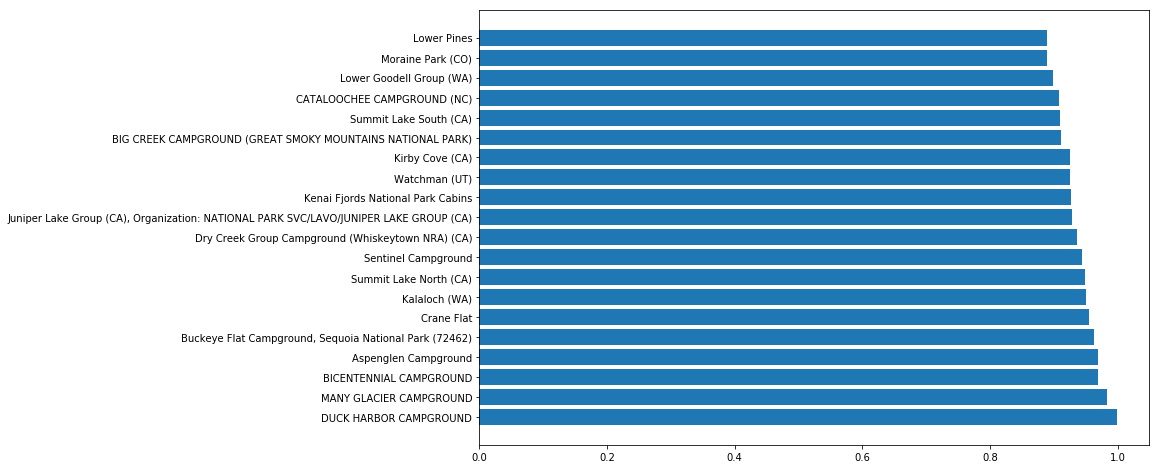

In [272]:
plt.figure(figsize = (12, 8))
plt.barh(pb_group.index, pb_group['PercentBooked'])

In [273]:
# define function to plot daily campsite data
def top_site_data(df, column, by = 'Site'):
    
    df_group = combined_rez.groupby([by]).agg({column: np.mean}).sort_values(by = column, ascending = False).head(20)
    
    plt.figure(figsize = (12, 8))
    plt.barh(df_group.index, df_group[column])

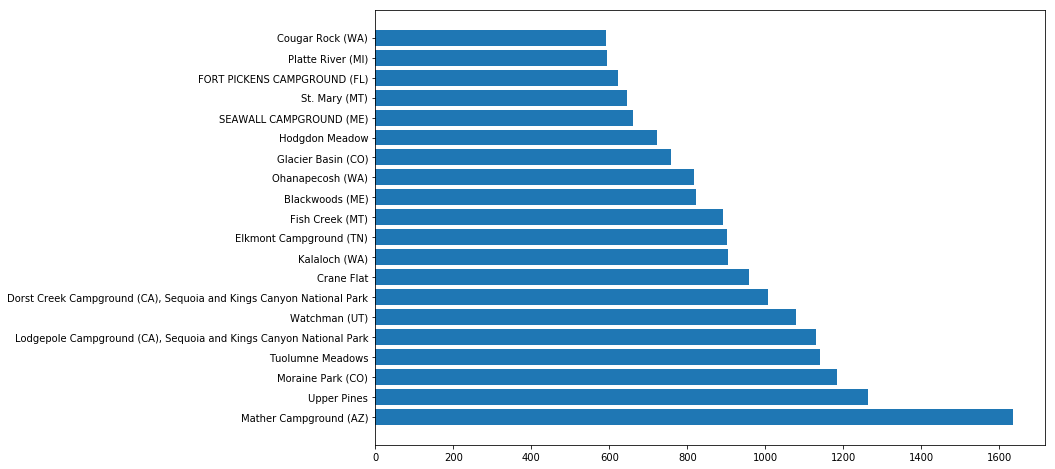

In [274]:
top_site_data(combined_rez, 'NumberOfPeople')

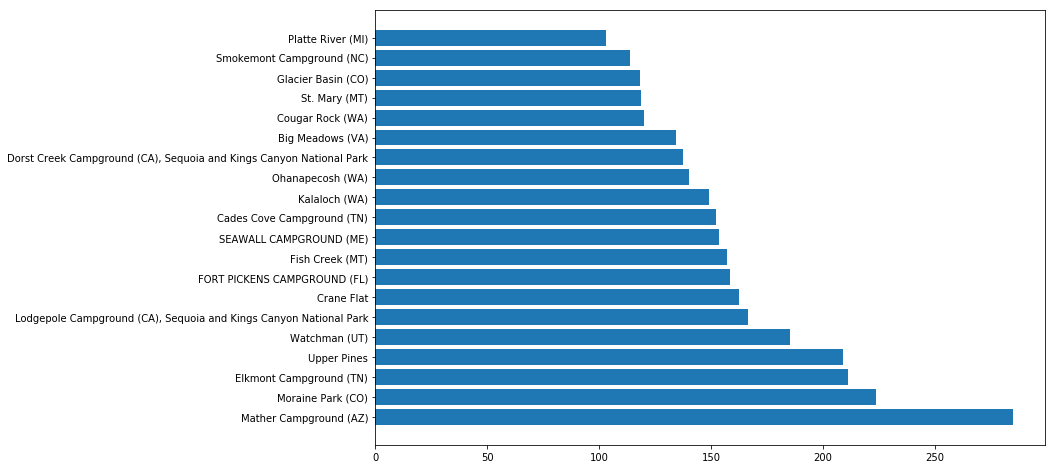

In [275]:
top_site_data(combined_rez, 'SitesBooked')

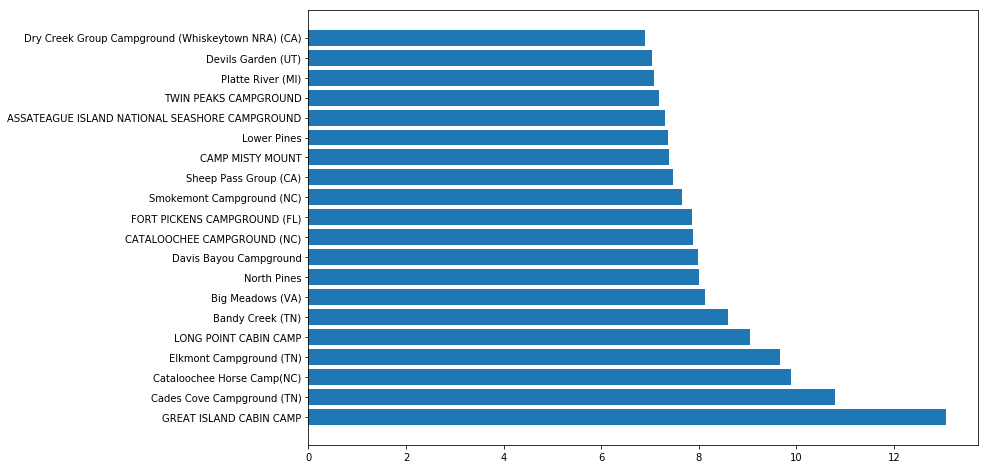

In [276]:
top_site_data(combined_rez, 'AvgStayLen')

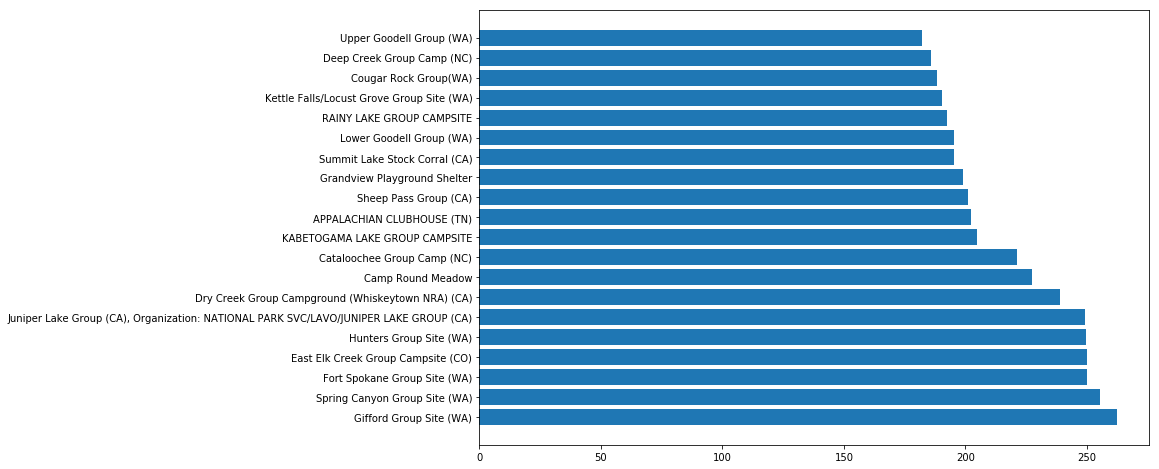

In [277]:
top_site_data(combined_rez, 'AvgBookingHorizon')

In [278]:
cg_target_ids

[232463, 232490, 232447, 232459, 232487, 232508, 234674]

In [279]:
def site_df (df, fid, sites):
    new_df = df[df['FacilityID'] == fid]
    idx = pd.date_range(new_df['Date'].min(), new_df['Date'].max())

    site_name = sites.loc[sites['FacilityID'] == fid]['Site'].values[0]
    park_name = df.loc[df['FacilityID'] == fid]['Park'].values[0]

    new_df.index = pd.DatetimeIndex(new_df['Date'])
    new_df = new_df[~new_df.index.duplicated(keep='first')]
    new_df = new_df.reindex(idx, fill_value = 0)

    new_df['Site'] = site_name
    new_df['Date'] = new_df.index
    new_df['Park'] = park_name
    new_df['FacilityID'] = fid
    
    return new_df

In [280]:
moraine = site_df(cg_target, 232463, site_data)

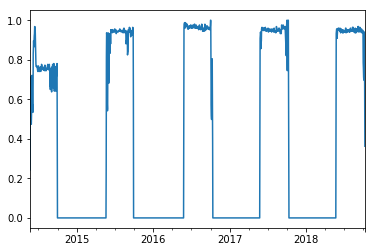

In [281]:
moraine['PercentBooked'].plot()

In [282]:
mather = site_df(cg_target, 232490, site_data)

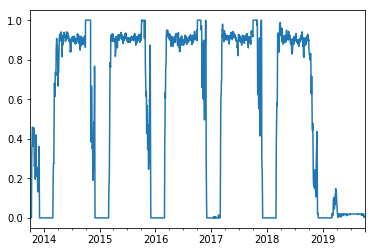

In [285]:
mather['PercentBooked'].plot()

In [287]:
blackwoods = site_df(cg_target, 232508, site_data)

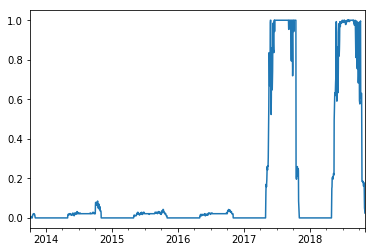

In [288]:
blackwoods['PercentBooked'].plot()

In [289]:
upper_pines = site_df(cg_target, 232447, site_data)

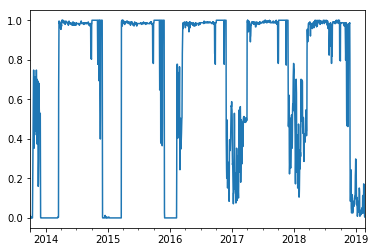

In [290]:
upper_pines['PercentBooked'].plot()

In [291]:
big_meadow = site_df(cg_target, 232459, site_data)

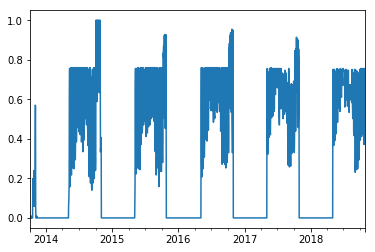

In [292]:
big_meadow['PercentBooked'].plot()

In [293]:
elkmont = site_df(cg_target, 232487, site_data)

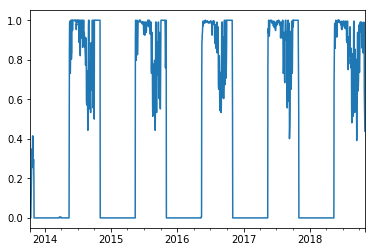

In [294]:
elkmont['PercentBooked'].plot()

In [295]:
seawall = site_df(cg_target, 234674, site_data)

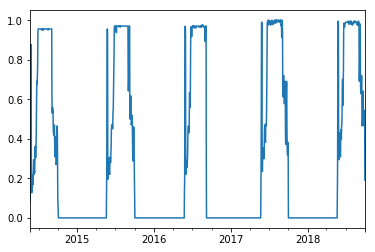

In [296]:
seawall['PercentBooked'].plot()

In [297]:
lodgepole = site_df(combined_rez, 232461, site_data)

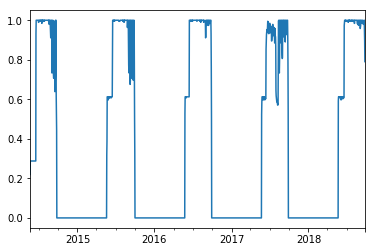

In [298]:
lodgepole['PercentBooked'].plot()

In [299]:
#export to csv
moraine.to_csv( "./data/Aggregated-Data/moraine_agg.csv", index=False, encoding='utf-8-sig')
mather.to_csv( "./data/Aggregated-Data/mather_agg.csv", index=False, encoding='utf-8-sig')
big_meadow.to_csv( "./data/Aggregated-Data/bigmeadow_agg.csv", index=False, encoding='utf-8-sig')
upper_pines.to_csv( "./data/Aggregated-Data/upperpines_agg.csv", index=False, encoding='utf-8-sig')
blackwoods.to_csv( "./data/Aggregated-Data/blackwoods_agg.csv", index=False, encoding='utf-8-sig')
elkmont.to_csv( "./data/Aggregated-Data/elkmont_agg.csv", index=False, encoding='utf-8-sig')
seawall.to_csv( "./data/Aggregated-Data/seawall_agg.csv", index=False, encoding='utf-8-sig')
lodgepole.to_csv( "./data/Aggregated-Data/lodgepole_agg.csv", index=False, encoding='utf-8-sig')